**do not hit run all, as this notebook is divided into two parts**

In [ ]:
!git clone https://github.com/Kaggle/learntools.git

fatal: destination path 'learntools' already exists and is not an empty directory.


In [ ]:
%cd learntools

/content/learntools/learntools


In [ ]:
!pip install .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
# Setup plotting
import matplotlib.pyplot as plt
from learntools.deep_learning_intro.dltools import animate_sgd
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

<ipython-input-11-69b99e41148c>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


With the learning rate and the batch size, you have some control over:


1.   How long it takes to train a model
2.   How noisy the learning curves are
3.   How small the loss becomes

To get a better understanding of these two parameters, we'll look at the linear model, our simplest neural network. Having only a single weight and a bias, it's easier to see what effect a change of parameter has.

The next cell will generate an animation. Change the values for learning_rate, batch_size, and num_examples (how many data points) and then run the cell. (It may take a moment or two.) Try the following combinations, or try some of your own:

In [ ]:
learning_rate = 0.9
batch_size = 4096
num_examples = 256

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these, if you like
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)

You probably saw that smaller batch sizes gave noisier weight updates and loss curves. This is because each batch is a small sample of data and smaller samples tend to give noisier estimates. Smaller batches can have an "averaging" effect though which can be beneficial.

Smaller learning rates make the updates smaller and the training takes longer to converge. Large learning rates can speed up training, but don't "settle in" to a minimum as well. When the learning rate is too large, the training can fail completely. (Try setting the learning rate to a large value like 0.99 to see this.)

# Neural Networks

We’ll now learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras import callbacks

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

spotify = pd.read_csv('https://raw.githubusercontent.com/raoulraft/Network-Intelligence-Course/main/spotify_dataset.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))



Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

Minimum Validation Loss: 0.1996


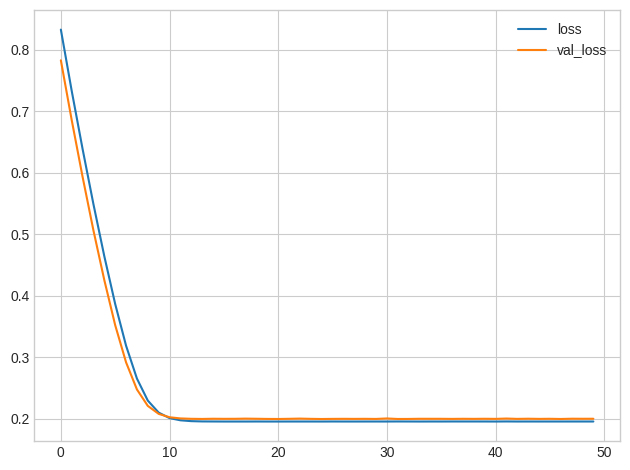

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1996


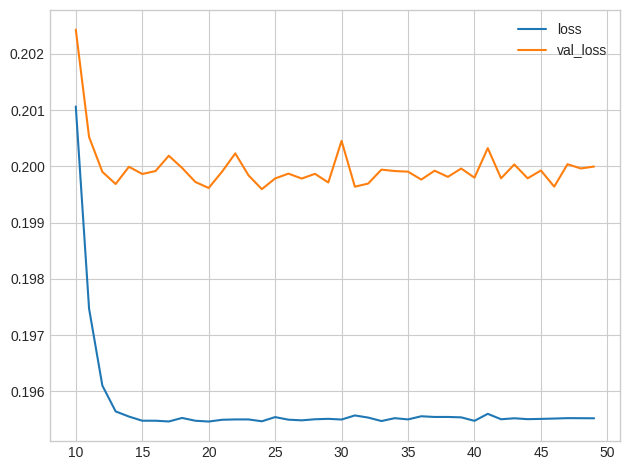

In [ ]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

What do you think? Would you say this model is underfitting, overfitting, just right?

Now let's add some capacity to our network. We'll add a couple of hidden layers with 192 units in all. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 2s 17ms/step - loss: 0.2392 - val_loss: 0.2088
Epoch 2/50
49/49 [==============================] - 1s 12ms/step - loss: 0.2002 - val_loss: 0.2045
Epoch 3/50
49/49 [==============================] - 1s 11ms/step - loss: 0.1950 - val_loss: 0.2015
Epoch 4/50
49/49 [==============================] - 1s 13ms/step - loss: 0.1921 - val_loss: 0.1995
Epoch 5/50
49/49 [==============================] - 1s 14ms/step - loss: 0.1903 - val_loss: 0.2001
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 0.1889 - val_loss: 0.2004
Epoch 7/50
49/49 [==============================] - 1s 27ms/step - loss: 0.1880 - val_loss: 0.2017
Epoch 8/50
49/49 [==============================] - 1s 22ms/step - loss: 0.1867 - val_loss: 0.2004
Epoch 9/50
49/49 [==============================] - 1s 24ms/step - loss: 0.1861 - val_loss: 0.1990
Epoch 10/50
49/49 [==============================] - 1s 12ms/step - loss: 0.1848 - val_loss: 0.1982
Epoch 11/

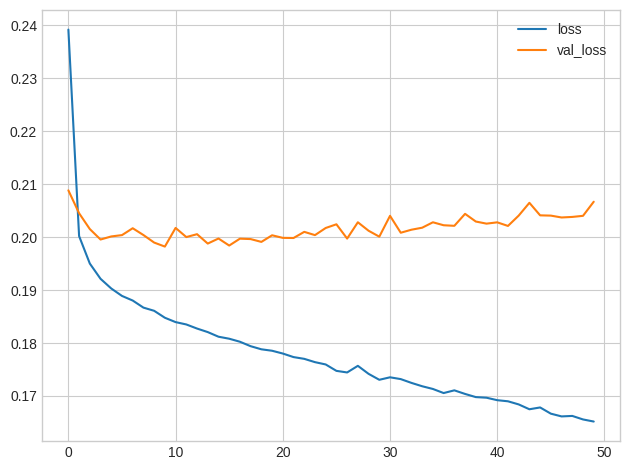

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

What is your evaluation of these curves? Underfitting, overfitting, just right?

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)


Now run this cell to train the model and get the learning curves. Notice the callbacks argument in model.fit.

Epoch 1/50
49/49 [==============================] - 1s 15ms/step - loss: 0.2503 - val_loss: 0.2107
Epoch 2/50
49/49 [==============================] - 0s 9ms/step - loss: 0.2020 - val_loss: 0.2052
Epoch 3/50
49/49 [==============================] - 0s 8ms/step - loss: 0.1969 - val_loss: 0.2018
Epoch 4/50
49/49 [==============================] - 0s 8ms/step - loss: 0.1931 - val_loss: 0.2027
Epoch 5/50
49/49 [==============================] - 0s 8ms/step - loss: 0.1912 - val_loss: 0.2002
Epoch 6/50
49/49 [==============================] - 0s 8ms/step - loss: 0.1891 - val_loss: 0.2002
Epoch 7/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1880 - val_loss: 0.2006
Epoch 8/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1870 - val_loss: 0.2007
Epoch 9/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1855 - val_loss: 0.1999
Epoch 10/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1853 - val_loss: 0.2034
Minimum Validation

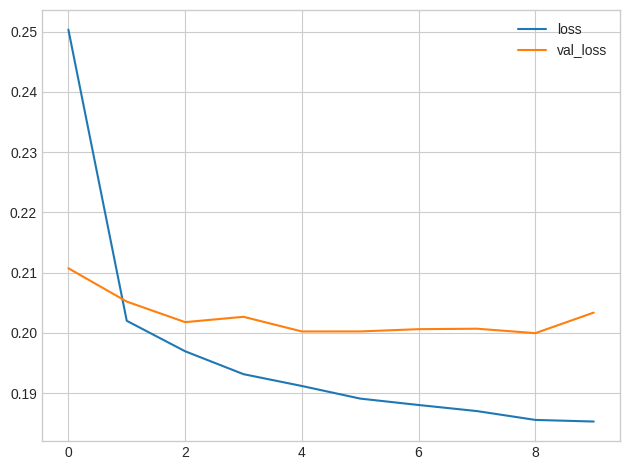

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Was this an improvement compared to training without early stopping?

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.

If you like, try experimenting with patience and min_delta to see what difference it might make.

# **STOP HERE BEFORE CONTINUING**

Let's add two dropout layers, one after the Dense layer with 128 units, and one after the Dense layer with 64 units. Set the dropout rate on both to 0.3.

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

Now run this next cell to train the model see the effect of adding dropout.

Minimum Validation Loss: 0.1950


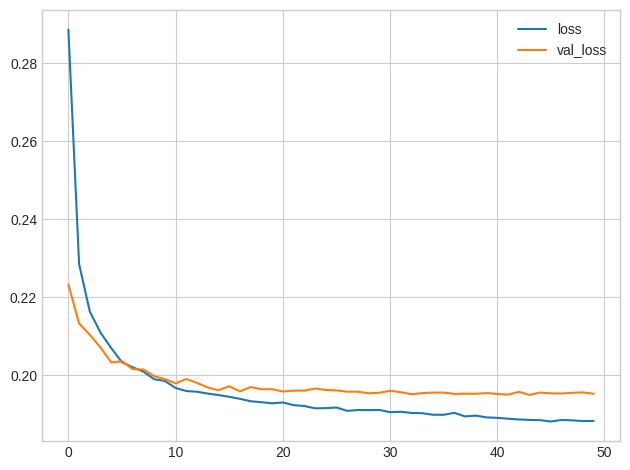

In [ ]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Did adding dropout seem to help prevent overfitting this time?

Now, we'll switch topics to explore how batch normalization can fix problems in training.

Load the Concrete dataset. We won't do any standardization this time. This will make the effect of batch normalization much more apparent.

In [ ]:
concrete = pd.read_csv('https://raw.githubusercontent.com/raoulraft/Network-Intelligence-Course/main/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Run the following cell to train the network on the unstandardized Concrete data.

Minimum Validation Loss: nan


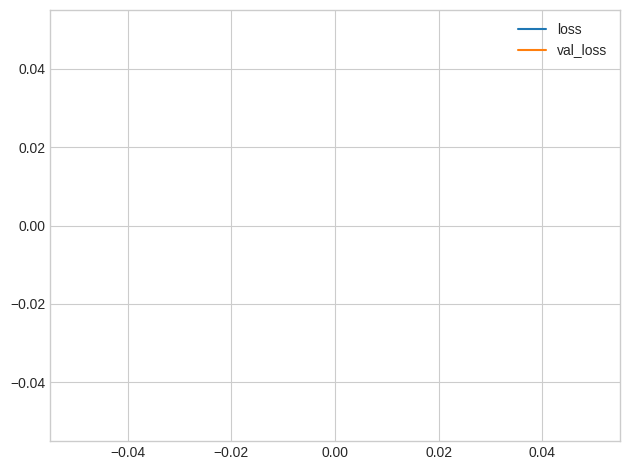

In [ ]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did you end up with a blank graph? Trying to train this network on this dataset will usually fail. Even when it does converge (due to a lucky weight initialization), it tends to converge to a very large number.

Batch normalization can help correct problems like this.

Add four BatchNormalization layers, one before each of the dense layers. (Remember to move the input_shape argument to the new first layer.)

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Run the next cell to see if batch normalization will let us train the model.

Minimum Validation Loss: 4.2505


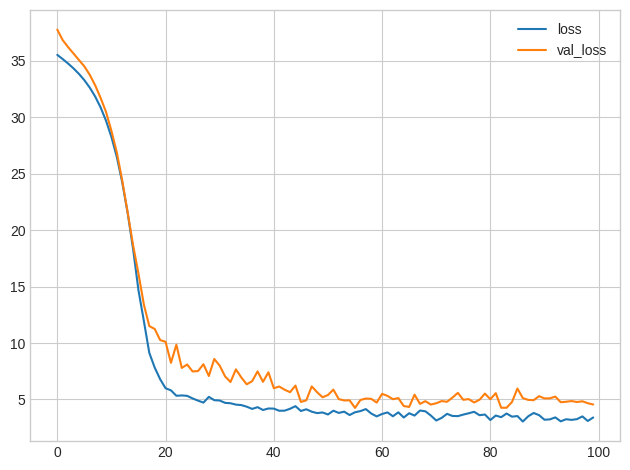

In [ ]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did adding batch normalization help?